In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.style.use('seaborn-notebook')

from soma.generators.nmist import NmistGenerator
from soma.tests import som_test

In [2]:
plot_dir = os.path.expanduser('~/Plots')
os.makedirs(plot_dir, exist_ok=True)

In [3]:
nmist2 = NmistGenerator(2)
nmist3 = NmistGenerator(3)

In [4]:
sample_size = 5000

In [5]:
nmist2_sample = nmist2.sample(sample_size)
nmist3_sample = nmist3.sample(sample_size)

In [6]:
p, som, (count_2, count_3) = som_test(nmist2_sample, nmist3_sample, ret_som=True, ret_counts=True)
p

0.0

In [7]:
best_2 = np.unravel_index(np.ma.masked_where(count_3 > 0, count_2).argmax(), count_2.shape)
best_3 = np.unravel_index(np.ma.masked_where(count_2 > 0, count_3).argmax(), count_2.shape)
worst_2 = np.unravel_index(np.ma.masked_where(count_2 == 0, count_3).argmax(), count_3.shape)
worst_3 = np.unravel_index(np.ma.masked_where(count_3 == 0, count_2).argmax(), count_2.shape)

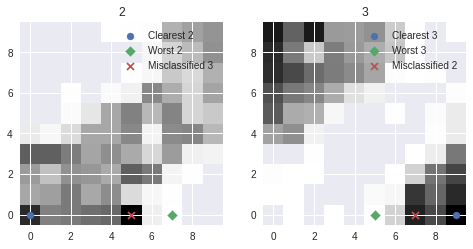

In [8]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(np.ma.masked_where(count_2 == 0, count_2).T, origin='lower')
axes[0].scatter([best_2[0]], [best_2[1]], marker='o', label='Clearest 2')
axes[0].scatter([worst_2[0]], [worst_2[1]], marker='D', label='Worst 2')
axes[0].scatter([worst_3[0]], [worst_3[1]], marker='x', label='Misclassified 3')
axes[0].legend()

axes[1].imshow(np.ma.masked_where(count_3 == 0, count_3).T, origin='lower')
axes[1].scatter([best_3[0]], [best_3[1]], marker='o', label='Clearest 3')
axes[1].scatter([worst_3[0]], [worst_3[1]], marker='D', label='Worst 3')
axes[1].scatter([worst_2[0]], [worst_2[1]], marker='x', label='Misclassified 2')
axes[0].set_title('2')
axes[1].set_title('3')
axes[1].legend()
plt.show()

In [9]:
mis_2_cell_idxs = np.argwhere((som.bmus == np.flip(worst_2)).all(axis=1))
mis_2 = mis_2_cell_idxs[mis_2_cell_idxs < sample_size][0]
good_3_sample = np.random.choice(mis_2_cell_idxs[mis_2_cell_idxs >= sample_size], size=9) - sample_size

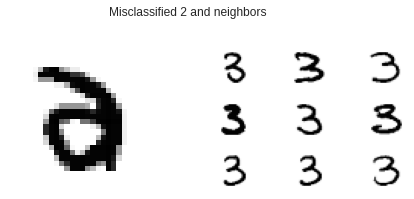

In [10]:
fig_mis_2 = plt.figure()
fig_mis_2.suptitle('Misclassified 2 and neighbors')

gs_mis_2 = GridSpec(ncols=6, nrows=6)

ax = fig_mis_2.add_subplot(gs_mis_2[0:3, 0:3])
ax.imshow(nmist2_sample[mis_2].reshape(28, 28))
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(good_3_sample)):
    y = 3 + i % 3
    x = i // 3
    ax = fig_mis_2.add_subplot(gs_mis_2[x, y])
    ax.imshow(nmist3_sample[good_3_sample[i]].reshape(28, 28))
    ax.set_xticks([])
    ax.set_yticks([])

fig_mis_2.show()

In [11]:
mis_3_cell_idxs = np.argwhere((som.bmus == np.flip(worst_3)).all(axis=1))
mis_3 = mis_3_cell_idxs[mis_3_cell_idxs >= sample_size][0] - sample_size
good_2_sample = np.random.choice(mis_3_cell_idxs[mis_3_cell_idxs < sample_size], size=9)

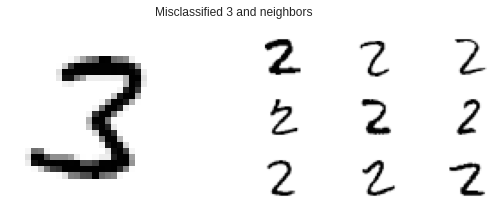

In [12]:
fig_mis_3 = plt.figure()
fig_mis_3.suptitle('Misclassified 3 and neighbors')

gs_mis_3 = GridSpec(ncols=6, nrows=6)

ax = fig_mis_3.add_subplot(gs_mis_3[0:3, 0:3])
ax.imshow(nmist3_sample[mis_3].reshape(28, 28))
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(good_2_sample)):
    y = 3 + i % 3
    x = i // 3
    ax = fig_mis_3.add_subplot(gs_mis_3[x, y])
    ax.imshow(nmist2_sample[good_2_sample[i]].reshape(28, 28))
    ax.set_xticks([])
    ax.set_yticks([])

fig_mis_3.show()
plt.tight_layout()

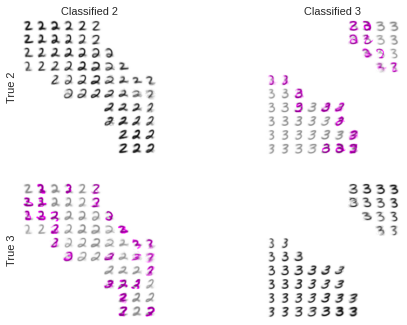

In [13]:
canvas2 = np.zeros((280, 280, 3))
canvas3 = np.zeros((280, 280, 3))
canvas_mis2 = np.zeros((280, 280, 3))
canvas_mis3 = np.zeros((280, 280, 3))

for i in range(28):
    for j in range(28):
        cell_idxs = np.argwhere((som.bmus[:, 0] == i) & (som.bmus[:, 1] == j))
        cell2_idxs = cell_idxs[cell_idxs < sample_size]
        cell3_idxs = cell_idxs[cell_idxs >= sample_size] - sample_size

        x = slice(i * 28, i * 28 + 28)
        y = slice(j * 28, j * 28 + 28)

        if len(cell2_idxs) > len(cell3_idxs):
            canvas2[x, y, :] = np.mean(nmist2_sample[cell2_idxs], axis=0).reshape(28, 28, 1) / 255.
            canvas_mis3[x, y, :] = 0.5 * canvas2[x, y, :]
        elif len(cell3_idxs) > len(cell2_idxs):
            canvas3[x, y, :] = np.mean(nmist3_sample[cell3_idxs], axis=0).reshape(28, 28, 1) / 255.
            canvas_mis2[x, y, :] = 0.5 * canvas3[x, y, :]

        if len(cell3_idxs) and len(cell2_idxs) > len(cell3_idxs):
            canvas_mis3[x, y, 1] += np.mean(nmist3_sample[cell3_idxs], axis=0).reshape(28, 28) / 255.
            canvas_mis3[x, y, 1] = np.clip(canvas_mis3[x, y, 1], 0, 1)
        if len(cell2_idxs) and len(cell3_idxs) > len(cell2_idxs):
            canvas_mis2[x, y, 1] += np.mean(nmist2_sample[cell2_idxs], axis=0).reshape(28, 28) / 255.
            canvas_mis2[x, y, 1] = np.clip(canvas_mis2[x, y, 1], 0, 1)

fig, axes = plt.subplots(ncols=2, nrows=2)

axes[0, 0].imshow(1 - canvas2)
axes[1, 1].imshow(1 - canvas3)
axes[0, 1].imshow(1 - canvas_mis2)
axes[1, 0].imshow(1 - canvas_mis3)

axes[0, 0].set_ylabel('True 2')
axes[0, 0].set_xlabel('Classified 2')
axes[1, 0].set_ylabel('True 3')
axes[0, 1].set_xlabel('Classified 3')

for ax in axes.ravel():
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_position('top')
fig.savefig(os.path.join(plot_dir, 'nmist_grid.eps'), bbox_inches='tight')
fig.show()